## Importing Libraries

In [2]:
import sagemaker
bucket=sagemaker.Session().default_bucket()
prefix = 'sagemaker/mlda'

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role() 

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

Now let's bring in the Python libraries that we'll use throughout the analysis

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker 

In [4]:
pd.__version__

'1.3.5'

Ensure pandas version is 1.2.4 or later, else upgrade and restart kernal and run again

## Importing Dataset
We will be importing our [medical dataset](https://sagemaker-ap-southeast-1-700356909758.s3.ap-southeast-1.amazonaws.com/data.csv) from our S3 bucket.

In [5]:
s3 = boto3.client("s3")
data_bucket = 'sagemaker-ap-southeast-1-700356909758'
data_path = "data.csv"

# downloading the test data from data_bucket
s3.download_file(data_bucket, 'data.csv', data_path)

In [6]:
data = pd.read_csv(data_path)
data.head()

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,0.0,72,1,37.588179,0,0,0,1,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,1,139812,0.0,75,2,NaN,0,0,0,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,1,109787,0.0,83,2,26.572634,0,0,0,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,1,130587,0.0,43,2,83.264629,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,1,138290,0.0,75,2,31.824842,1,0,0,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55


In [7]:
data["outcome"].sort_values(ascending=False)

314     1.0
869     1.0
964     1.0
246     1.0
258     1.0
       ... 
417     0.0
419     0.0
420     0.0
1176    0.0
1159    NaN
Name: outcome, Length: 1177, dtype: float64

Let's have an overview of our data.

* We have a little over 1000 customer records, and 20 features for each customer
* The features are mixed; some numeric, some categorical
* The data appears to be sorted, at least by `time` and `contact`, maybe more

_**Specifics on each of the features:**_

group
ID
outcome
age
gendera
BMI
hypertensive
atrialfibrillation
CHD with no MI
diabetes
deficiencyanemias
depression
Hyperlipemia
Renal failure
COPD
heart rate
Systolic blood pressure
Diastolic blood pressure
Respiratory rate
temperature
SP O2
Urine output
hematocrit
RBC
MCH
MCHC
MCV
RDW
Leucocyte
Platelets
Neutrophils
Basophils
Lymphocyte
PT
INR
NT-proBNP
Creatine kinase
Creatinine
Urea nitrogen
glucose
Blood potassium
Blood sodium
Blood calcium
Chloride
Anion gap
Magnesium ion
PH
Bicarbonate
Lactic acid
PCO2
EF


In [8]:
data.describe()

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
count,1177.000000,1177.000000,1176.000000,1177.000000,1177.000000,962.000000,1177.000000,1177.000000,1177.000000,1177.000000,...,1177.000000,1176.000000,1177.000000,1177.000000,1177.000000,885.000000,1177.000000,948.000000,883.000000,1177.000000
mean,1.299065,150778.120646,0.135204,74.055225,1.525064,30.188278,0.717927,0.451147,0.085811,0.421410,...,138.890016,8.500894,102.283835,13.925094,2.120169,7.378532,26.911766,1.853426,45.535382,48.715378
std,0.458043,29034.669513,0.342087,13.434061,0.499584,9.325997,0.450200,0.497819,0.280204,0.493995,...,4.151347,0.572263,5.339733,2.652732,0.251532,0.067320,5.167512,0.983819,12.711271,12.868436
min,1.000000,100213.000000,0.000000,19.000000,1.000000,13.346801,0.000000,0.000000,0.000000,0.000000,...,114.666667,6.700000,80.266667,6.636364,1.400000,7.090000,12.857143,0.500000,18.750000,15.000000
25%,1.000000,125603.000000,0.000000,65.000000,1.000000,24.326461,0.000000,0.000000,0.000000,0.000000,...,136.666667,8.148864,99.000000,12.250000,1.955556,7.334615,23.454545,1.200000,37.038462,40.000000
50%,1.000000,151901.000000,0.000000,77.000000,2.000000,28.312474,1.000000,0.000000,0.000000,0.000000,...,139.250000,8.500000,102.500000,13.666667,2.092308,7.380000,26.500000,1.600000,43.000000,55.000000
75%,2.000000,176048.000000,0.000000,85.000000,2.000000,33.633509,1.000000,1.000000,0.000000,1.000000,...,141.600000,8.869063,105.571429,15.416667,2.241667,7.430000,29.875000,2.200000,50.585784,55.000000
max,2.000000,199952.000000,1.000000,99.000000,2.000000,104.970366,1.000000,1.000000,1.000000,1.000000,...,154.736842,10.950000,122.526316,25.500000,4.072727,7.580000,47.666667,8.333333,98.600000,75.000000


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   group                     1177 non-null   int64  
 1   ID                        1177 non-null   int64  
 2   outcome                   1176 non-null   float64
 3   age                       1177 non-null   int64  
 4   gendera                   1177 non-null   int64  
 5   BMI                       962 non-null    float64
 6   hypertensive              1177 non-null   int64  
 7   atrialfibrillation        1177 non-null   int64  
 8   CHD with no MI            1177 non-null   int64  
 9   diabetes                  1177 non-null   int64  
 10  deficiencyanemias         1177 non-null   int64  
 11  depression                1177 non-null   int64  
 12  Hyperlipemia              1177 non-null   int64  
 13  Renal failure             1177 non-null   int64  
 14  COPD    

## Checking NA Values

In [10]:
null = data.isnull().sum()
null[null>0].sort_values(ascending=False)

PCO2                        294
PH                          292
Basophils                   259
Lactic acid                 229
BMI                         215
Creatine kinase             165
Lymphocyte                  145
Neutrophils                 144
Urine output                 36
INR                          20
PT                           20
temperature                  19
glucose                      18
Systolic blood pressure      16
Diastolic blood pressure     16
SP O2                        13
heart rate                   13
Respiratory rate             13
Blood calcium                 1
outcome                       1
dtype: int64

### Drop insignificant rows

##### Row 1159 has insufficient information, hence we will remove it  

In [11]:
data = data.drop([1159])

### Checking data types of columns of with null values

In [12]:
data[null[null>0].index].dtypes

outcome                     float64
BMI                         float64
heart rate                  float64
Systolic blood pressure     float64
Diastolic blood pressure    float64
Respiratory rate            float64
temperature                 float64
SP O2                       float64
Urine output                float64
Neutrophils                 float64
Basophils                   float64
Lymphocyte                  float64
PT                          float64
INR                         float64
Creatine kinase             float64
glucose                     float64
Blood calcium               float64
PH                          float64
Lactic acid                 float64
PCO2                        float64
dtype: object

In [13]:
null[null>0].index


Index(['outcome', 'BMI', 'heart rate', 'Systolic blood pressure',
       'Diastolic blood pressure', 'Respiratory rate', 'temperature', 'SP O2',
       'Urine output', 'Neutrophils', 'Basophils', 'Lymphocyte', 'PT', 'INR',
       'Creatine kinase', 'glucose', 'Blood calcium', 'PH', 'Lactic acid',
       'PCO2'],
      dtype='object')

### Fill null values

##### Since all our null columns are numeric, we can fill them with the median value

In [14]:
#Remove the null values and put in median
null_col = ['outcome', 'BMI', 'heart rate', 'Systolic blood pressure',
       'Diastolic blood pressure', 'Respiratory rate', 'temperature', 'SP O2',
       'Urine output', 'Neutrophils', 'Basophils', 'Lymphocyte', 'PT', 'INR',
       'Creatine kinase', 'glucose', 'Blood calcium', 'PH', 'Lactic acid',
       'PCO2']

data[null_col] = data[null_col].fillna(data[null_col].median())

In [15]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176 entries, 0 to 1176
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   group                     1176 non-null   int64  
 1   ID                        1176 non-null   int64  
 2   outcome                   1176 non-null   float64
 3   age                       1176 non-null   int64  
 4   gendera                   1176 non-null   int64  
 5   BMI                       1176 non-null   float64
 6   hypertensive              1176 non-null   int64  
 7   atrialfibrillation        1176 non-null   int64  
 8   CHD with no MI            1176 non-null   int64  
 9   diabetes                  1176 non-null   int64  
 10  deficiencyanemias         1176 non-null   int64  
 11  depression                1176 non-null   int64  
 12  Hyperlipemia              1176 non-null   int64  
 13  Renal failure             1176 non-null   int64  
 14  COPD    

None

## Exploratory Data Analysis

### Distribution Plots

### Outcome

In [16]:
sns.catplot(x = "outcome",data = data, kind = "count")

#### Plotting correlation heatmap for numerical variables
##### We will drop the categorical variables

In [17]:

data_numerical = data.drop(columns=['group','age','ID', 'gendera', 'hypertensive', 'atrialfibrillation', 'CHD with no MI' , 'diabetes', 'deficiencyanemias', 
'depression', 'Hyperlipemia', 'Renal failure', 'COPD'])
data_numerical.shape[1]

38

In [18]:
# #Drawing distribution for all variables

# f, axes = plt.subplots(data_numerical.shape[1], 3, figsize=(37, 25))
# f.tight_layout(pad = 3.0)

# count = 0
# for var in data_numerical:
#     sns.boxplot(data = data[[var]], orient = "h", ax = axes[count,0])
#     sns.histplot(data = data[[var]], ax = axes[count,1])
#     sns.violinplot(data = data[[var]], orient = "h", ax = axes[count,2])
#     count += 1
  
# plt.show()

In [19]:
plt.figure(figsize=(1,20))

data_numerical.corrwith(data_numerical['outcome']).sort_values(ascending = False, key = abs)

outcome                     1.000000
Anion gap                   0.229676
Lactic acid                 0.224992
Bicarbonate                -0.222650
Leucocyte                   0.208274
Urea nitrogen               0.203024
Blood calcium              -0.184058
Urine output               -0.170494
RDW                         0.148089
INR                         0.145349
PH                         -0.141628
PT                          0.141209
Blood potassium             0.136940
Systolic blood pressure    -0.132084
heart rate                  0.129393
Lymphocyte                 -0.129202
NT-proBNP                   0.121075
Respiratory rate            0.116770
temperature                -0.092344
Platelets                  -0.088465
Diastolic blood pressure   -0.086819
Magnesium ion               0.074033
SP O2                      -0.071062
Creatine kinase             0.070671
Blood sodium               -0.066366
Neutrophils                 0.066188
BMI                        -0.061739
C

### Distribution of top 5 correlated variables with Outcome

In [20]:
# f,ax = plt.subplots(nrows = 2, ncols = 2,figsize=(30, 6))
# f.tight_layout(pad=4.0)

# # Reg Plot
# sns.regplot(ax = ax[0][0], x = "XXX", y = "XXX", color = "red", data = data)
# ax[0][0].set_title("XXX vs Outcome RegPlot")

# # Box Plot
# sns.boxplot(ax = ax[0][1], x = "XXX", color = "red", data = data)
# ax[0][1].set_title("XXX")

# # Dist Plot
# sns.distplot(ax = ax[1][0], x=data["XXX"], color="red")
# ax[1][0].set_title("XXX + before Log(1+x)")
# data["XXX"] = np.log1p(data["XXX"])
# sns.distplot(ax = ax[1][1], x=data["XXX"], color="purple")
# ax[1][1].set_title("XXX + after Log(1+x)")
# plt.show()

## Feature Engineering

### Remove unrelated columns

In [21]:
data = data.drop(["group","ID"],axis=1)

#### Identify Skewed Numeric Variables

In [22]:
skew = data_numerical.skew()
skew[abs(skew)>1].sort_values(ascending = False, key = abs)

Creatine kinase    27.049371
Basophils          11.492976
Creatinine          3.988830
INR                 2.740117
PT                  2.708074
Lymphocyte          2.700180
Lactic acid         2.597486
Leucocyte           2.587841
BMI                 2.572413
Neutrophils        -2.216225
NT-proBNP           2.143913
outcome             2.136401
PCO2                1.540333
Platelets           1.489313
Urea nitrogen       1.483855
glucose             1.480872
Urine output        1.443498
SP O2              -1.393286
RDW                 1.378396
Magnesium ion       1.290889
dtype: float64

### Box Cox Transformation for Skewed Numeric Variables
##### Identify numeric variables which are skewed and apply transformation

In [23]:
skew = data_numerical.drop('outcome',axis=1).skew()
skew = skew[abs(skew)>1]

from scipy.special import boxcox1p
skewed_features = skew.index
lam = 0.15
for i in skewed_features:
    data[i] = boxcox1p(data[i], lam)

## Training with SageMaker XGB Model

We'll simply randomly split the data into 3 uneven groups.  The model will be trained on 70% of data, it will then be evaluated on 20% of data to give us an estimate of the accuracy we hope to have on "new" data, and 10% will be held back as a final testing dataset which will be used later on.

In [112]:
train_data, validation_data, test_data = np.split(data.sample(frac=1, random_state=1729), [int(0.7 * len(data)), int(0.9 * len(data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%

Amazon SageMaker's XGBoost container expects data in the libSVM or CSV data format.  For this example, we'll stick to CSV.  Note that the first column must be the target variable and the CSV should not include headers.  Also, notice that although repetitive it's easiest to do this after the train|validation|test split rather than before.  This avoids any misalignment issues due to random reordering.

In [113]:
pd.concat([train_data['outcome'], train_data.drop('outcome', axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['outcome'], validation_data.drop('outcome', axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

Now we'll copy the file to S3 for Amazon SageMaker's managed training to pickup.

In [114]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

First we'll need to specify the ECR container location for Amazon SageMaker's implementation of XGBoost.

In [115]:
container = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='latest')

In [116]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

First we'll need to specify training parameters to the estimator.  This includes:
1. The `xgboost` algorithm container
2. The IAM role to use
3. Training instance type and count
4. S3 location for output data
5. Algorithm hyperparameters

And then a `.fit()` function which specifies:
1. S3 location for output data.  In this case we have both a training and validation set which are passed in.

First we'll need to specify the ECR container location for Amazon SageMaker's implementation of XGBoost.

In [117]:
container = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='latest')

Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3, which also specify that the content type is CSV.

In [118]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [ ]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge', #ml.m4.xlarge
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

INFO:sagemaker:Creating training-job with name: xgboost-2023-03-12-10-55-27-124


2023-03-12 10:55:27 Starting - Starting the training job...
2023-03-12 10:55:42 Starting - Preparing the instances for training..

---

#### Hosting
Now that we've trained the `xgboost` algorithm on our data, let's deploy a model that's hosted behind a real-time endpoint.

In [ ]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

---

#### Evaluation
There are many ways to compare the performance of a machine learning model, but let's start by simply comparing actual to predicted values.  In this case, we're simply predicting whether the customer subscribed to a term deposit (`1`) or not (`0`), which produces a simple confusion matrix.

First we'll need to determine how we pass data into and receive data from our endpoint.  Our data is currently stored as NumPy arrays in memory of our notebook instance.  To send it in an HTTP POST request, we'll serialize it as a CSV string and then decode the resulting CSV.

*Note: For inference with CSV format, SageMaker XGBoost requires that the data does NOT include the target variable.*

In [ ]:
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()

Now, we'll use a simple function to:
1. Loop over our test dataset
2. Split it into mini-batches of rows 
3. Convert those mini-batches to CSV string payloads (notice, we drop the target variable from our dataset first)
4. Retrieve mini-batch predictions by invoking the XGBoost endpoint
5. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [ ]:
def predict(data, predictor, rows=500 ):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop('outcome', axis=1).to_numpy(), xgb_predictor)

Now we'll check our confusion matrix to see how well we predicted versus actuals.

In [ ]:
pd.crosstab(index=test_data['outcome'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

#### Automatic model Tuning (optional)
Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose.
For example, suppose that you want to solve a binary classification problem on this marketing dataset. Your goal is to maximize the area under the curve (auc) metric of the algorithm by training an XGBoost Algorithm model. You don't know which values of the eta, alpha, min_child_weight, and max_depth hyperparameters to use to train the best model. To find the best values for these hyperparameters, you can specify ranges of values that Amazon SageMaker hyperparameter tuning searches to find the combination of values that results in the training job that performs the best as measured by the objective metric that you chose. Hyperparameter tuning launches training jobs that use hyperparameter values in the ranges that you specified, and returns the training job with highest auc.

In [ ]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                            'min_child_weight': ContinuousParameter(1, 10),
                            'alpha': ContinuousParameter(0, 2),
                            'max_depth': IntegerParameter(1, 10)}

In [ ]:
objective_metric_name = 'validation:auc'

In [ ]:
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3)

In [ ]:
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [ ]:
tuner.best_training_job()

In [ ]:
#  Deploy the best trained or user specified model to an Amazon SageMaker endpoint
tuner_predictor = tuner.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

In [ ]:
# Create a serializer
tuner_predictor.serializer = sagemaker.serializers.CSVSerializer()

In [ ]:
# Predict
predictions = predict(test_data.drop('outcome', axis=1).to_numpy(),tuner_predictor)

In [ ]:
# Collect predictions and convert from the CSV output our model provides into a NumPy array
pd.crosstab(index=test_data['outcome'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

#### (Optional) Clean-up

If you are done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
# xgb_predictor.delete_endpoint(delete_endpoint_config=True)
# tuner_predictor.delete_endpoint(delete_endpoint_config=True)

## Building Models
- LightGBM Classifier (lgbmc)
- Random Forest Classifier (rfc)
- Tensorflow Keras (ann_model)

In [26]:
X = data.iloc[:,1:]
y = data.iloc[:,0]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X))


### Train test split


In [46]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

#### Resampling

In [30]:
# !pip install -U imbalanced-learn


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [47]:
import sklearn
from imblearn.over_sampling import SMOTE

# Create a SMOTE object
smote = SMOTE()

# Fit the SMOTE object to the training data and apply the transformation
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Print the number of samples in each class after oversampling
print("Class distribution after oversampling: \n", y_resampled.value_counts())


Class distribution after oversampling: 
 0.0    765
1.0    765
Name: outcome, dtype: int64


In [48]:
X_train = X_resampled
y_train = y_resampled

### LightGBM

In [34]:
# pip install lightgbm

In [81]:
import lightgbm as lgb
lgbmc = lgb.LGBMClassifier()

#### LGBMC 5-fold Cross Validation

In [82]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score

In [87]:
accuracy_scores_lgbmc_cv = cross_val_score(lgbmc, X_train, y_train, cv=5, scoring='accuracy')
mean_accuracy_lgbmc_cv = np.mean(accuracy_scores_lgbmc_cv)
print("Mean cross-validation accuracy (train): {:.2f}".format(mean_accuracy_lgbmc_cv))

f1_scores_lgbmc_cv = cross_val_score(lgbmc, X_train, y_train, cv=5, scoring='f1')
mean_f1_lgbmc_cv = np.mean(f1_scores_lgbmc_cv)
print("Mean cross-validation f1 (train): {:.2f}\n".format(mean_f1_lgbmc_cv))

lgbmc.fit(X_train, y_train)
y_pred_lgbmc = lgbmc.predict(X_test)
test_f1_lgbmc = f1_score(y_test, y_pred_lgbmc)
test_accuracy_lgbmc = accuracy_score(y_test, y_pred_lgbmc)
print("Accuracy (test): {:.2f}".format(test_accuracy_lgbmc))
print("F1 (test): {:.2f}".format(test_f1_lgbmc))

Mean cross-validation accuracy (train): 0.95
Mean cross-validation f1 (train): 0.95

Accuracy (test): 0.84
F1 (test): 0.34


### Random Forest 

In [53]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')

#### RFC 5-fold Cross Validation

In [88]:
accuracy_scores_rfc_cv = cross_val_score(rfc, X_train, y_train, cv=5, scoring='accuracy')
mean_accuracy_rfc_cv = np.mean(accuracy_scores_rfc_cv)
print("Mean cross-validation accuracy (train): {:.2f}".format(mean_accuracy_rfc_cv))

f1_scores_rfc_cv = cross_val_score(rfc, X_train, y_train, cv=5, scoring='f1')
mean_f1_rfc_cv = np.mean(f1_scores_rfc_cv)
print("Mean cross-validation f1 (train): {:.2f} \n".format(mean_f1_rfc_cv))

rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
test_f1_rfc = f1_score(y_test, y_pred_rfc)
test_accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
print("Accuracy (test): {:.2f}".format(test_accuracy_rfc))
print("F1 (test): {:.2f}".format(test_f1_rfc))

Mean cross-validation accuracy (train): 0.92
Mean cross-validation f1 (train): 0.92 

Accuracy (test): 0.84
F1 (test): 0.30


### Tensorflow Keras

In [42]:
# pip install tensorflow

In [94]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
# Neural network
ann_model = Sequential()
ann_model.add(Dense(12, input_dim=X.shape[1], activation='relu'))
ann_model.add(Dense(6, activation='relu'))
ann_model.add(Dense(6, activation='relu'))
ann_model.add(Dense(1, activation='sigmoid'))
#opt = SGD(lr=0.01)
ann_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [95]:
history = ann_model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
48/48 [==============================] - 1s 1ms/step - loss: 0.6639 - accuracy: 0.6301
Epoch 2/30
48/48 [==============================] - 0s 1ms/step - loss: 0.6112 - accuracy: 0.7418
Epoch 3/30
48/48 [==============================] - 0s 1ms/step - loss: 0.5625 - accuracy: 0.7810
Epoch 4/30
48/48 [==============================] - 0s 1ms/step - loss: 0.5094 - accuracy: 0.8111
Epoch 5/30
48/48 [==============================] - 0s 1ms/step - loss: 0.4451 - accuracy: 0.8412
Epoch 6/30
48/48 [==============================] - 0s 1ms/step - loss: 0.3863 - accuracy: 0.8497
Epoch 7/30
48/48 [==============================] - 0s 1ms/step - loss: 0.3476 - accuracy: 0.8601
Epoch 8/30
48/48 [==============================] - 0s 1ms/step - loss: 0.3214 - accuracy: 0.8706
Epoch 9/30
48/48 [==============================] - 0s 2ms/step - loss: 0.3013 - accuracy: 0.8817
Epoch 10/30
48/48 [==============================] - 0s 1ms/step - loss: 0.2842 - accuracy: 0.8869
Epoch 11/30
48/48 [

## Accuracy Scores of Models

In [96]:
y_pred_ann = np.around(ann_model.predict(X_test))
test_accuracy_ann = accuracy_score(y_test,y_pred_ann)
test_f1_ann = f1_score(y_test,y_pred_ann)
print("Accuracy (test): {:.2f}".format(test_accuracy_ann))
print("F1 (test): {:.2f}".format(test_f1_ann))

10/10 [==============================] - 0s 1ms/step
Accuracy (test): 0.81
F1 (test): 0.42


## F1 Scores of Models

In [109]:
models = pd.DataFrame(
    {
      "Classification Model":["LightGBM", "RandomForest", "ANN"],
      "Accuracy Score (test)": [test_accuracy_lgbmc,test_accuracy_rfc,test_accuracy_ann],
      "F1 Score (test)": [test_f1_lgbmc,test_f1_rfc,test_f1_ann]
    }  
  )

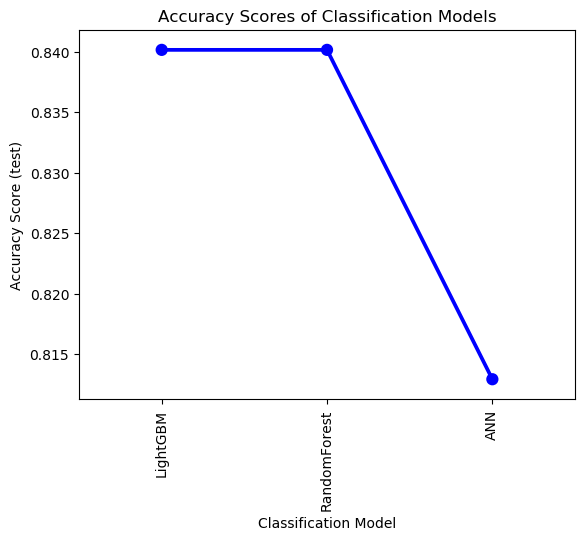

In [110]:
plt.show()
sns.pointplot(x = "Classification Model", y = "Accuracy Score (test)",
           data = models, color = "Blue")
plt.title("Accuracy Scores of Classification Models")
plt.xticks(rotation = 90)
plt.show()

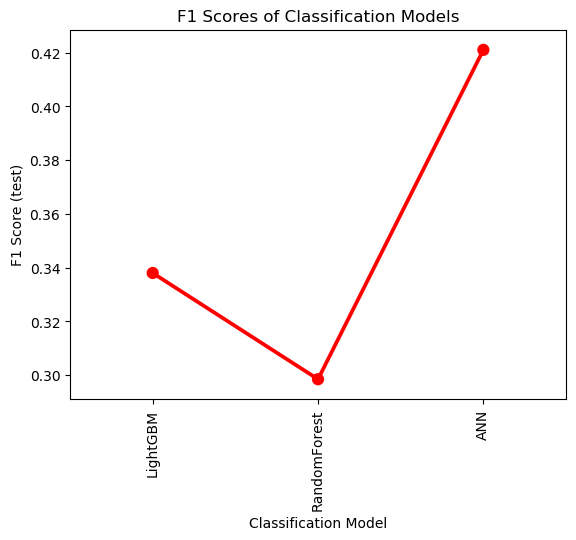

In [111]:
plt.show()
sns.pointplot(x = "Classification Model", y = "F1 Score (test)",
           data = models, color = "Red")
plt.title("F1 Scores of Classification Models")
plt.xticks(rotation = 90)
plt.show()


## Conclusion

### Best model and its best parameters
While ANN has the lower test accuracy than some of the other models, it has the highest F1 Score, which accounts for false negatives and false positives.
In the medical world where false negatives and false positives are important, F1 Score is a slightly more important metric.

Hence ANN model would be the best for classifying our patients